# Import e funzioni

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
import pywt
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
import matplotlib.image as mpimg
from dtaidistance import dtw, clustering
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

In [1]:


def plot_silhouette(X, labels, n_cluster, metric='euclidean'):
    X = X[labels != -1]
    labels = labels[labels != -1]
    sil_score = silhouette_score(X, labels, metric=metric)
    sil_samples = silhouette_samples(X, labels, metric=metric)

    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    ax.set_xlim([-0.1,1])
    ax.set_ylim([0, len(X) + (n_cluster + 1)*10])

    y_lower = 10
    for i in range(n_cluster):
        ith_cluster_silhouette_values = sil_samples[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_cluster)

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + (0.5 * size_cluster_i), str(i))
        y_lower = y_upper + 10


    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=sil_score, color="red", linestyle="--")

    plt.show()

    return sil_score

In [2]:
def get_element(table, column_name, index):
    return table.loc[:, column_name].iloc[index]

In [3]:
def view_clusters(labels, data, time_data):
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    for i in range(len(labels)):
        ax.plot(time_data, data[i], color= cm.nipy_spectral(float(labels[i]) / len(np.unique(labels))))
    plt.show()

# Caricamento dataset

- Preparazione dei dati, le colonne vengono rimoninate e si crea un data frame per ogni indicatore

In [44]:
dt = pd.read_csv("dataset.csv")
dt = dt.loc[:, ~dt.columns.isin(['Country Code', 'Indicator Name', 'Attribute', 'Unnamed: 226'])]
dt = dt.rename(columns= {"Country Name":"name", "Indicator Code": "code"})
display(dt.head())

country_list = dt.name.unique()
indicator_list = dt.code.unique()
time_data = dt.columns[2:].to_numpy(dtype=np.int64)

,name,code,1800,1801,1802,1803,1804,1805,1806,1807,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Papua New Guinea,GGXWDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.006838e+09,8.565531e+09,1.176576e+10,1.482730e+10,1.580891e+10,1.616781e+10,1.670647e+10,1.667034e+10,1.633275e+10,1.552917e+10
1,Paraguay,GGXWDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.366880e+13,1.760297e+13,2.096252e+13,2.633586e+13,3.298367e+13,3.828361e+13,4.343323e+13,4.902607e+13,5.462696e+13,6.051216e+13
2,Peru,GGXWDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.081839e+11,1.077037e+11,1.110170e+11,1.193030e+11,1.350758e+11,1.550643e+11,1.683184e+11,1.783528e+11,1.863985e+11,1.995994e+11
3,Philippines,GGXWDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.020388e+12,4.288804e+12,4.529800e+12,4.602500e+12,4.853522e+12,5.038158e+12,5.246268e+12,5.472505e+12,5.722527e+12,5.997655e+12
4,Poland,GGXWDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.514290e+11,8.784150e+11,9.261160e+11,8.665020e+11,9.144117e+11,9.600945e+11,1.011376e+12,1.059549e+12,1.101687e+12,1.146170e+12


In [45]:
prod_dt = dt.loc[dt['code'] == 'NGDP']
debt_dt = dt.loc[dt['code'] == 'GGXWDG']
rate_dt = dt.loc[dt['code'] == 'GGXWDG_GDP']

# Analisi esplorativa

- Per ogni paese prendiamo il primo anno avvalorato e contiamo per ogni anno quanti paesi hanno come data per l'inizio dei dati l'anno considerato.
- Il primo grafico indica il numero di paesi (su un totale di 193) che hanno come hanno di inizio dei valori l'anno sull'asse X.
- Il secondo grafico mostra invece il totale dei paesi avvalorati all'aumentare del tempo.

[(1800, 2), (1814, 1), (1815, 1), (1830, 1), (1835, 1), (1850, 1), (1851, 1), (1860, 2), (1861, 1), (1870, 4), (1875, 1), (1886, 1), (1900, 5), (1911, 1), (1913, 2), (1920, 1), (1923, 1), (1924, 3), (1925, 2), (1927, 1), (1928, 1), (1929, 1), (1932, 1), (1936, 2), (1939, 2), (1940, 1), (1946, 3), (1947, 1), (1948, 1), (1949, 1), (1950, 13), (1951, 1), (1952, 1), (1953, 3), (1955, 2), (1960, 5), (1961, 2), (1962, 29), (1963, 42), (1965, 4), (1969, 1), (1970, 1), (1979, 1), (1985, 1), (1986, 1), (1989, 1), (1990, 6), (1991, 3), (1992, 13), (1993, 2), (1994, 1), (1995, 2), (1997, 3), (2000, 5), (2002, 1), (2004, 1), (2011, 1)]
(1963, 42)
[0.01036269 0.01554404 0.02072539 0.02590674 0.03108808 0.03626943
 0.04145078 0.05181347 0.05699482 0.07772021 0.08290155 0.0880829
 0.11398964 0.11917098 0.12953368 0.13471503 0.13989637 0.15544041
 0.16580311 0.17098446 0.1761658  0.18134715 0.1865285  0.19689119
 0.20725389 0.21243523 0.22797927 0.23316062 0.23834197 0.24352332
 0.31088083 0.31606218 

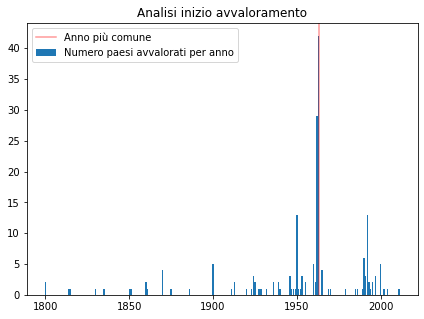

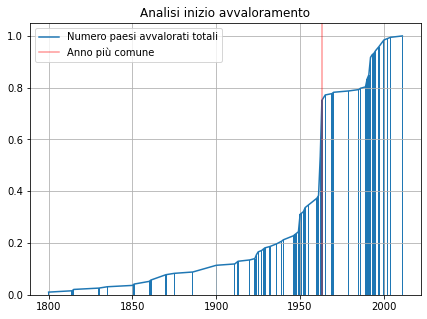

In [60]:
DATASET = prod_dt
year_counter = DATASET.iloc[:,2:].apply(pd.Series.first_valid_index, axis=1).to_numpy(dtype=np.int64)
year_counter = np.sort(year_counter)



counts = Counter(year_counter)
data = sorted(counts.items())

print(data)

print(counts.most_common()[0])
x = [el[0] for el in data]
y = [el[1] for el in data]




new_y = []

for i in range(len(y)):
    value = 0
    for j in range(0,i+1):
        value = value + y[j]
    new_y.append(value)


        
new_y = np.array(new_y) / len(DATASET.loc[:,'name'])

print(new_y)

plt.rcParams["figure.figsize"] = (7,5)
plt.title("Analisi inizio avvaloramento")
plt.bar(x,y, label='Numero paesi avvalorati per anno')
plt.axvline(x=counts.most_common()[0][0], color='r', label='Anno più comune', alpha=0.4)
plt.legend()
plt.show()

plt.title("Analisi inizio avvaloramento")
plt.bar(x, new_y)
plt.plot(x,new_y, label='Numero paesi avvalorati totali')
plt.axvline(x=counts.most_common()[0][0], color='r', label='Anno più comune', alpha=0.4)
plt.legend()
plt.grid()
plt.show()

In [8]:
prod_dt.describe()

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02
mean,2.861610e+08,3.236589e+08,3.075772e+08,3.032994e+08,3.221775e+08,3.573090e+08,3.718485e+08,3.521310e+08,3.084318e+08,3.312689e+08,...,1.105250e+14,1.242219e+14,1.446557e+14,1.622515e+14,1.780808e+14,2.006526e+14,2.230582e+14,2.466019e+14,2.717929e+14,3.005445e+14
std,2.444312e+08,2.889820e+08,2.579847e+08,2.612061e+08,2.995622e+08,3.319031e+08,3.353829e+08,2.996280e+08,2.157640e+08,2.414502e+08,...,7.548006e+14,8.435757e+14,1.001824e+15,1.137584e+15,1.257024e+15,1.430889e+15,1.600638e+15,1.772667e+15,1.948755e+15,2.138552e+15
min,1.133220e+08,1.193177e+08,1.251545e+08,1.185988e+08,1.103551e+08,1.226181e+08,1.346969e+08,1.402620e+08,1.558636e+08,1.605379e+08,...,3.811172e+07,3.851205e+07,3.969433e+07,4.166088e+07,4.438041e+07,4.702143e+07,4.896146e+07,5.092667e+07,5.281813e+07,5.455087e+07
25%,1.997415e+08,2.214883e+08,2.163659e+08,2.109491e+08,2.162663e+08,2.399636e+08,2.532727e+08,2.461965e+08,2.321477e+08,2.459034e+08,...,3.668154e+10,3.824738e+10,4.343035e+10,4.531033e+10,4.693295e+10,4.981513e+10,5.363335e+10,5.795044e+10,6.282095e+10,6.781918e+10
50%,2.861610e+08,3.236589e+08,3.075772e+08,3.032994e+08,3.221775e+08,3.573090e+08,3.718485e+08,3.521310e+08,3.084318e+08,3.312689e+08,...,6.183246e+11,6.689095e+11,6.928600e+11,7.157172e+11,6.990067e+11,7.322567e+11,7.786931e+11,8.624934e+11,9.573029e+11,1.110220e+12
75%,3.725805e+08,4.258294e+08,3.987886e+08,3.956497e+08,4.280888e+08,4.746545e+08,4.904242e+08,4.580655e+08,3.847159e+08,4.166345e+08,...,5.229287e+12,5.854010e+12,6.118790e+12,6.350200e+12,6.483899e+12,7.200220e+12,8.086710e+12,8.990822e+12,9.999690e+12,1.080310e+13
max,4.590000e+08,5.280000e+08,4.900000e+08,4.880000e+08,5.340000e+08,5.920000e+08,6.090000e+08,5.640000e+08,4.610000e+08,5.020000e+08,...,7.831726e+15,8.615704e+15,9.524736e+15,1.103367e+16,1.208855e+16,1.416584e+16,1.607203e+16,1.784666e+16,1.953867e+16,2.133356e+16


- Mostriamo per i vari indicatori la percentuale di dati mancanti all'aumentare del tempo


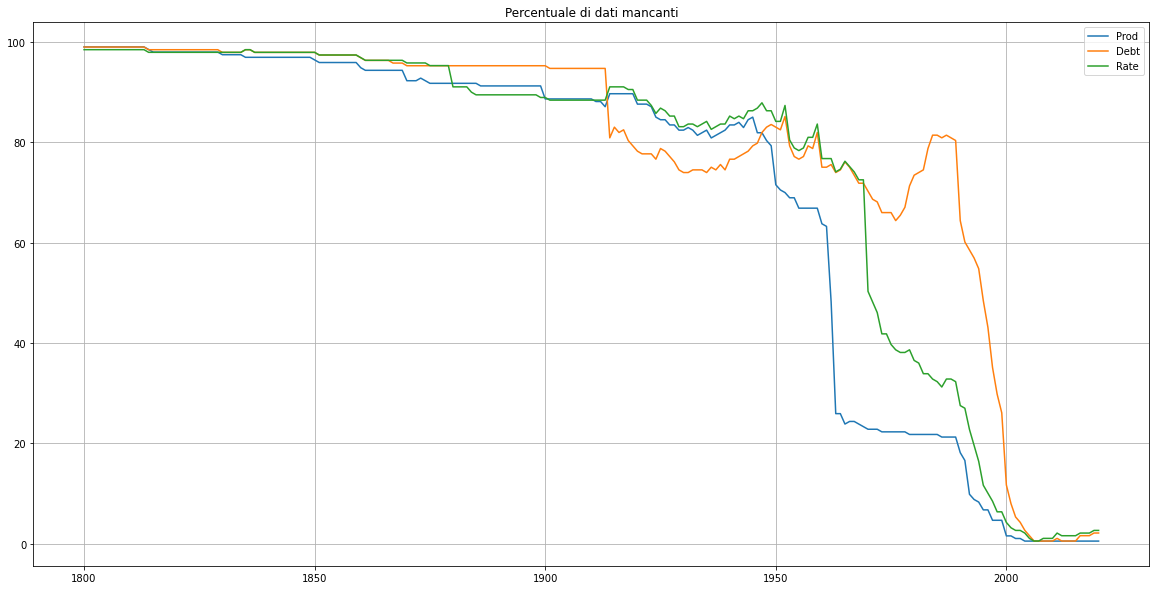

In [52]:

missing_prod_dt = prod_dt.isna().sum().to_numpy()[2:] / len(prod_dt) * 100
missing_debt_dt = debt_dt.isna().sum().to_numpy()[2:] / len(debt_dt) * 100
missing_rate_dt = rate_dt.isna().sum().to_numpy()[2:] / len(rate_dt) * 100


plt.rcParams["figure.figsize"] = (20,10)
plt.title("Percentuale di dati mancanti")
plt.plot(time_data, missing_prod_dt, label="Prod")
plt.plot(time_data, missing_debt_dt, label="Debt")
plt.plot(time_data, missing_rate_dt, label="Rate")
#plt.axvline(x=counts.most_common()[0][0], color='r', label='Anno più comune', alpha=0.4)
plt.legend()
plt.grid()

plt.show()




In [101]:
DATASET = debt_dt
MISSING = DATASET.isna().sum().to_numpy()[2:] / len(DATASET) * 100
START = 2000

print("Analisi dati mancanti per paese (percentuale):")
print(f"\tx < 25% di dati mancanti:\t{round((sum(i < 25 for i in MISSING[(START - 1800):])/(2020 - START + 1))* 100, 2 )}%")
print(f"25% <= x < 50%  di dati mancanti: \t{round((sum(i >= 25 and i < 50 for i in MISSING[(START - 1800):])/(2020 - START + 1))* 100, 2 )}%")
print(f"50% <= x < 75%  di dati mancanti: \t{round((sum(i >= 50 and i < 75 for i in MISSING[(START - 1800):])/(2020 - START+ 1))* 100, 2 )}%")
print(f"       x >= 75% di dati mancanti:\t{round((sum(i >= 75 for i in MISSING[(START - 1800):])/(2020 - START+ 1))* 100, 2 )}%")
print()
print(f"Media dati mancanti dal 1800 al 2020: {round(sum(MISSING)/221,2)}%")
print(f"Media dati mancanti dal 1800 al {START}: {round(sum(MISSING[0: START - 1800])/ (START - 1800 + 1),2)}%")
print(f"Media dati mancanti dal {START} al 2020: {round(sum(MISSING[START - 1800:])/((221 - (START - 1800))),2)}%")



Analisi dati mancanti per paese (percentuale):
	x < 25% di dati mancanti:	100.0%
25% <= x < 50%  di dati mancanti: 	0.0%
50% <= x < 75%  di dati mancanti: 	0.0%
       x >= 75% di dati mancanti:	0.0%

Media dati mancanti dal 1800 al 2020: 78.56%
Media dati mancanti dal 1800 al 2000: 86.14%
Media dati mancanti dal 2000 al 2020: 2.3%


Min:3.909000e-03
Max:3.650229e+16
99.944%
 0.056%


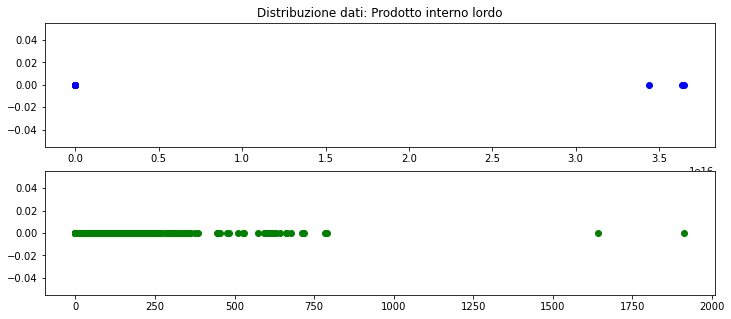

In [125]:

DATASET = rate_dt
precision = 2000


ac_data = DATASET.iloc[:, 2:].stack().to_numpy()
print(f"Min:{np.min(ac_data):e}")
print(f"Max:{np.max(ac_data):e}")

ac_data_1 = ac_data[ac_data <= precision]
ac_data_2 = ac_data[ac_data > precision]

print(f"{round(len(ac_data_1)/ len(ac_data) *100, 3):>6}%")
print(f"{round(len(ac_data_2)/ len(ac_data) *100, 3):>6}%")

fig, axs = plt.subplots(2,1)
fig.set_size_inches(12, 5)
axs[0].set_title("Distribuzione dati: Prodotto interno lordo")
axs[0].scatter(ac_data_1, np.zeros(ac_data_1.shape), color='r')
axs[0].scatter(ac_data_2, np.zeros(ac_data_2.shape), color='b')
axs[1].scatter(ac_data_1, np.zeros(ac_data_1.shape), color='g')
plt.show()






In [68]:
imputer = KNNImputer(n_neighbors=1, metric="nan_euclidean")
x = np.array([[1,2,np.nan,3,np.nan,1,np.nan,5,np.nan,8]]).transpose()
print(x.transpose())
print(imputer.fit_transform(x).transpose())



[[ 1.  2. nan  3. nan  1. nan  5. nan  8.]]
[[1.         2.         3.33333333 3.         3.33333333 1.
  3.33333333 5.         3.33333333 8.        ]]


- Rimozione elementi null

/tmp/ipykernel_5014/2745095447.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


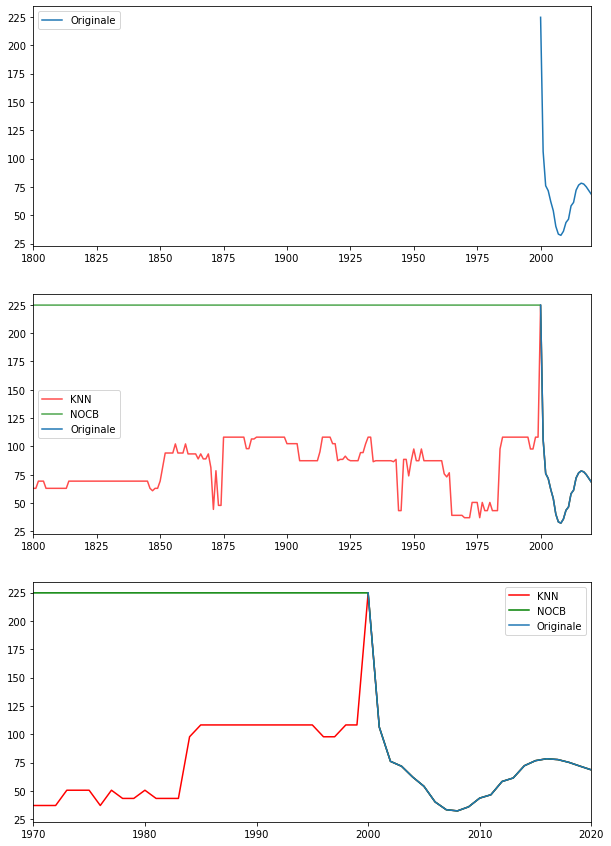

In [52]:
DATASET = rate_dt
TIME_STOP = 1970
INDEX = 10
data = DATASET.iloc[:, 2:].to_numpy()
fig, axs = plt.subplots(3,1)
fig.set_size_inches(10,15)
N_NEIGH = 5

imputer = KNNImputer(n_neighbors=N_NEIGH)
ac_data = imputer.fit_transform(data.transpose()).transpose()
ac_data_back = DATASET.iloc[:, 2:].fillna(method="backfill", axis=1).to_numpy()


axs[0].plot(time_data, data[INDEX], label="Originale" )
axs[0].set_xlim([1800, 2020])
axs[0].legend()


axs[1].plot(time_data, ac_data[INDEX], label="KNN", color='r', alpha=0.7)
axs[1].plot(time_data, ac_data_back[INDEX], label="NOCB", color='g', alpha=0.7)
axs[1].plot(time_data, data[INDEX], label="Originale" )
axs[1].set_xlim([1800, 2020])
axs[1].legend()


data = DATASET.iloc[:, (TIME_STOP - 1800)+2:].to_numpy()
imputer = KNNImputer(n_neighbors=N_NEIGH)
ac_data = imputer.fit_transform(data.transpose()).transpose()
ac_data_back = DATASET.iloc[:, (TIME_STOP - 1800)+2:].fillna(method="backfill", axis=1).to_numpy()

axs[2].plot(time_data[TIME_STOP - 1800:], ac_data[INDEX], label="KNN", color='r')
axs[2].plot(time_data[TIME_STOP - 1800:], ac_data_back[INDEX], label="NOCB", color='g')
axs[2].plot(time_data[TIME_STOP - 1800:], data[INDEX], label="Originale")
axs[2].set_xlim([TIME_STOP, 2020])
axs[2].legend()


fig.show()




# Clustering su dato multidimensionale

Primo approccio naive, non si considerano le serie temporali, problema di alta dimensionalità

(193, 21)
193
0 98.44559585492227
1 1.0362694300518136
2 0.5181347150259068


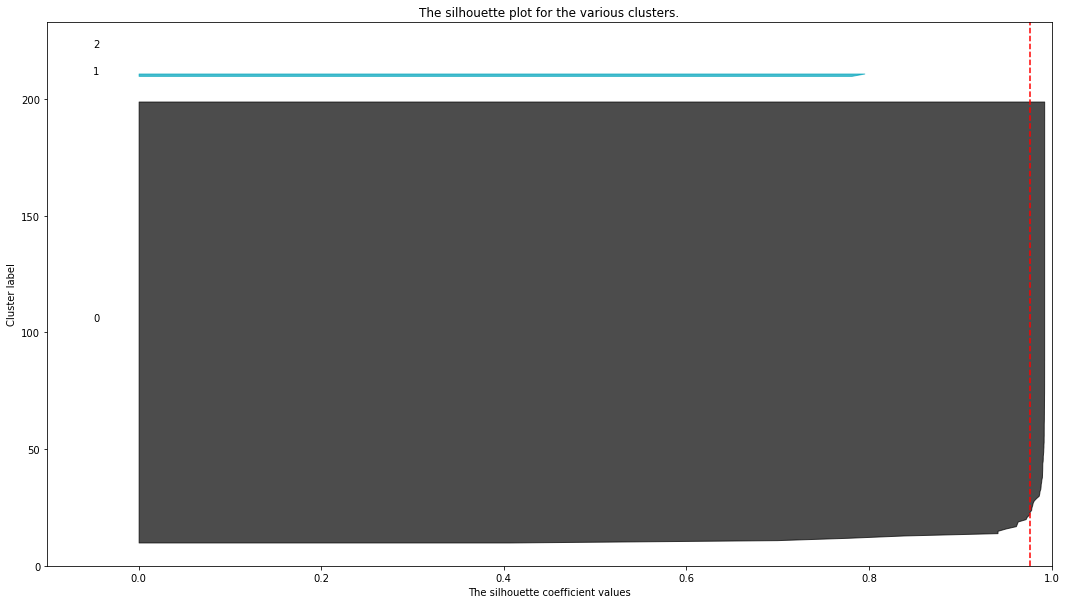

0.9756655886561694


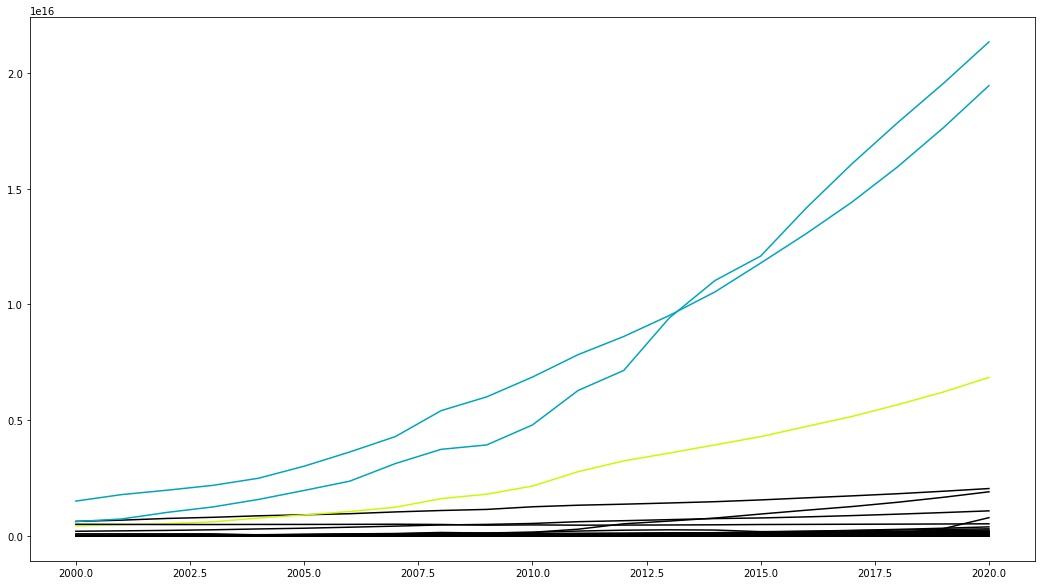

In [109]:
'''
KMEANS su PAESI 
'''

# Parametri

START = 2000
TRAINING_DATA = prod_dt
n_cluster = 3
n_neighbors = 5

# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose()).transpose()
print(data.shape)

# Clustering



clustering = KMeans(n_clusters=n_cluster).fit(data)



# Visualizzazione risultati

labels = clustering.labels_

print(len(labels))

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)


score = plot_silhouette(data, labels, n_cluster)
print(score)

view_clusters(labels, data, time_data[START - 1800:])


(51, 189)
51
1 49.01960784313725
0 27.450980392156865
2 23.52941176470588


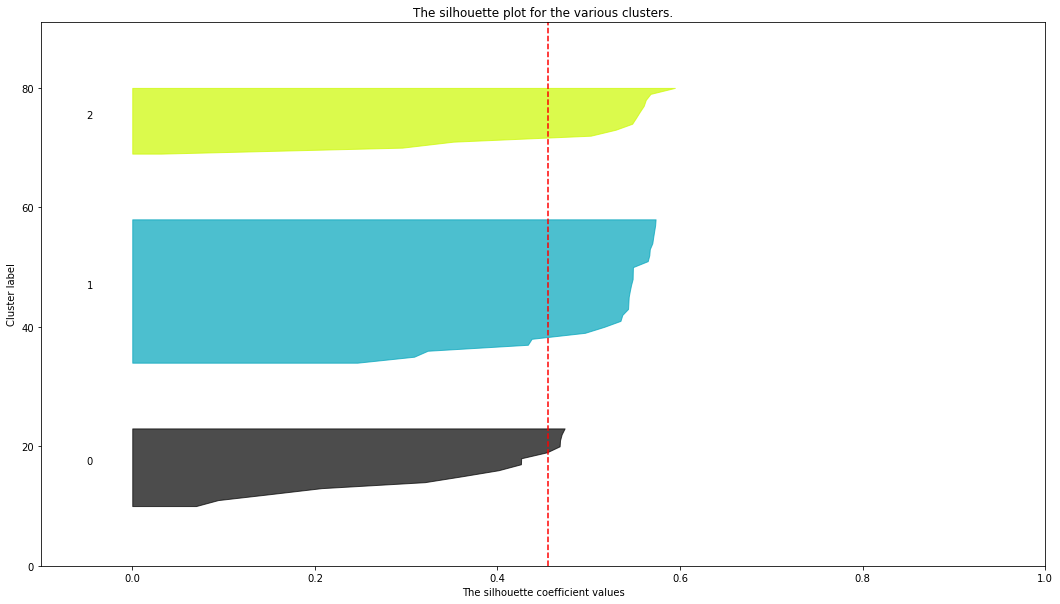

0.45480137003139287


In [114]:
'''
KMEANS su ANNI
'''

# Parametri

START = 1970
TRAINING_DATA = rate_dt
n_cluster = 3
n_neighbors = 5

# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose())
print(data.shape)

# Clustering

clustering = KMeans(n_clusters=n_cluster).fit(data)

# Visualizzazione risultati

labels = clustering.labels_

print(len(labels))

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)


score = plot_silhouette(data, labels, n_cluster)
print(score)




(189, 51)
189
2 62.43386243386243
0 35.44973544973545
1 2.1164021164021163


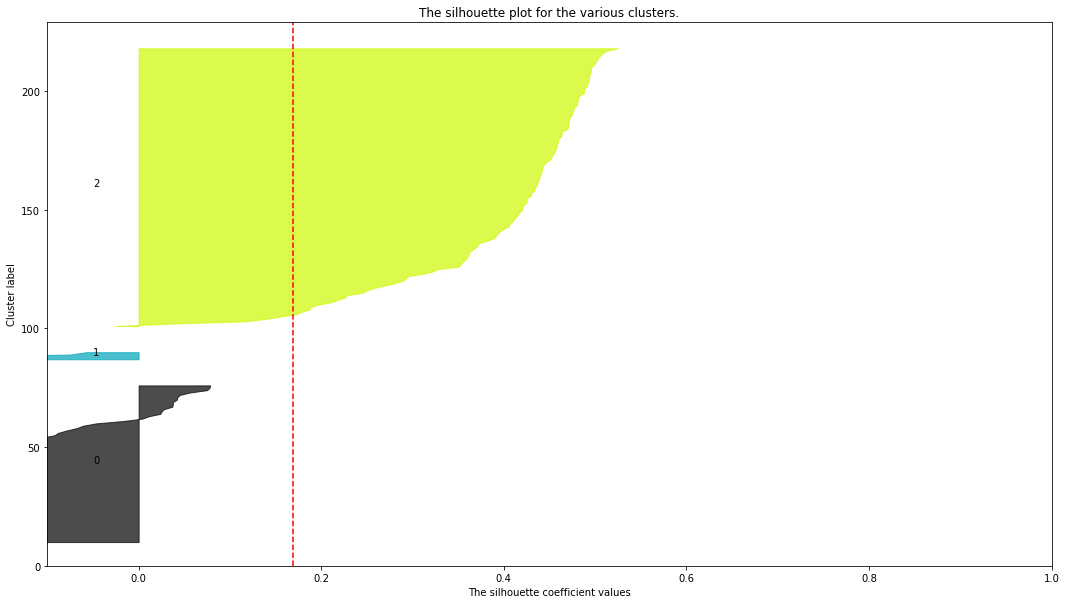

0.16877473729566603


ValueError: x and y must have same first dimension, but have shapes (11,) and (51,)

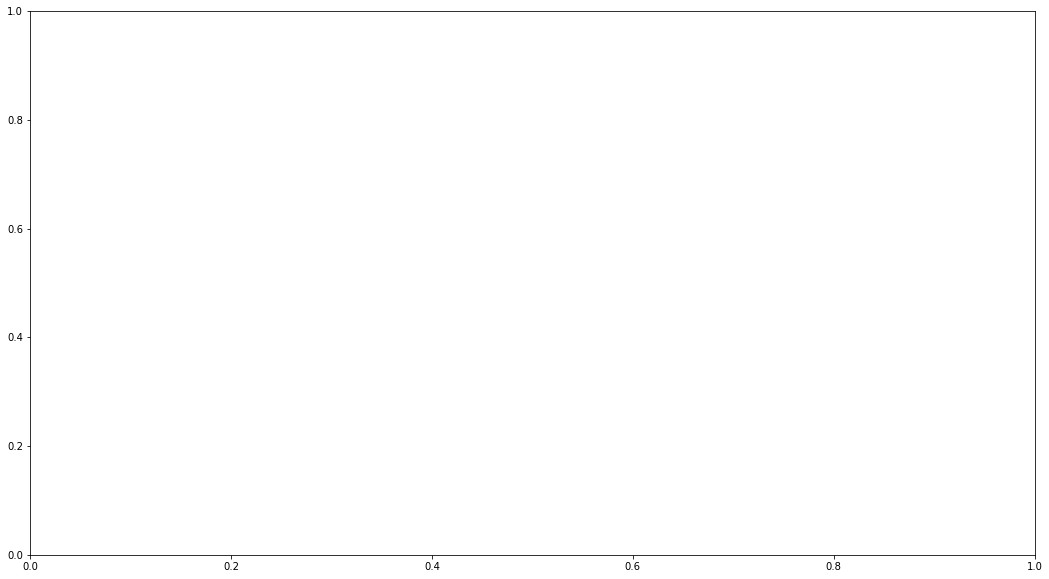

In [65]:
'''
Agglomerative su PAESI
'''

# Parametri

'''
affinity: euclidean, l1,l2, manhattan, cosine
linnkage: single, complete, average, ward
'''

START = 1970
TRAINING_DATA = rate_dt
n_cluster = 3
n_neighbors = 5
affinity = 'cosine'
linkage = 'complete'

# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose()).transpose()
print(data.shape)

# Clustering

clustering = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, compute_full_tree=True, linkage=linkage).fit(data)

# Visualizzazione risultati

labels = clustering.labels_

print(len(labels))

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)


score = plot_silhouette(data, labels, n_cluster)
print(score)


(51, 189)
51
2 1.9607843137254901
1 49.01960784313725
3 1.9607843137254901
0 47.05882352941176


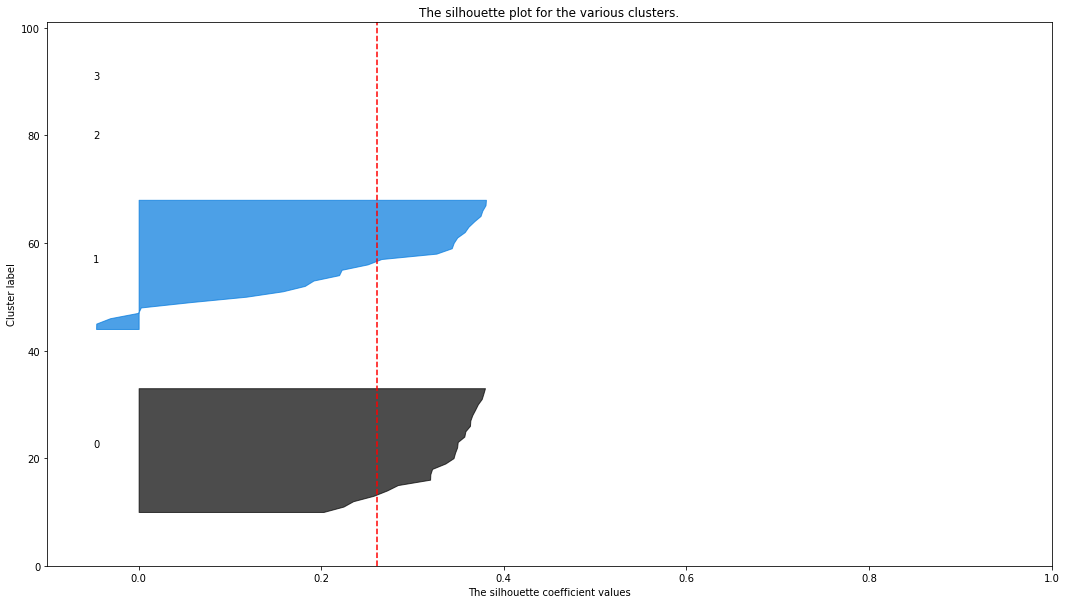

0.261587408443758


In [135]:
'''
Agglomerative su ANNI
'''

# Parametri
plt.plot([i for i in range(2,20)], val)
plt.show()
'''
affinity: euclidean, l1,l2, manhattan, cosine
linnkage: single, complete, average, ward
'''

START = 1970
TRAINING_DATA = rate_dt
n_cluster = 4
n_neighbors = 5
affinity = 'cosine'
linkage = 'complete'

# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose())
print(data.shape)plt.plot([i for i in range(2,20)], val)
plt.show()
    print(a, c.get(a) / len(labels) * 100)


score = plot_silhouette(data, labels, n_cluster)
print(score)


(189, 51)
[-1 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1  0
  0 -1  0  1  0  0 -1  2 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1
 -1  0  3 -1  0 -1  4 -1 -1 -1  5 -1 -1  0 -1  0 -1 -1 -1 -1  0  0 -1 -1
 -1 -1 -1 -1  0 -1  6  6 -1 -1 -1 -1 -1  0  0  7  0 -1 -1 -1  8  0 -1 -1
 -1 -1 -1 -1  0 -1 -1 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0  0  0 -1
 -1 -1  0 -1 -1  8  9 -1 -1  0 -1 -1  0 -1 -1 -1 -1  0 -1 -1 -1  1  0  7
 -1 -1  0 -1 -1  0  0  5  0 -1 -1  0 -1  0 -1 -1 -1  3  4  0 -1 -1 -1 -1
  0 -1 -1  0 -1  0  2 -1 -1  0 -1 -1  0  5 -1  0 -1 -1  9  0 -1]
189
-1 65.07936507936508
0 24.33862433862434
1 1.0582010582010581
2 1.0582010582010581
3 1.0582010582010581
4 1.5873015873015872
5 1.5873015873015872
6 1.0582010582010581
7 1.0582010582010581
8 1.0582010582010581
9 1.0582010582010581


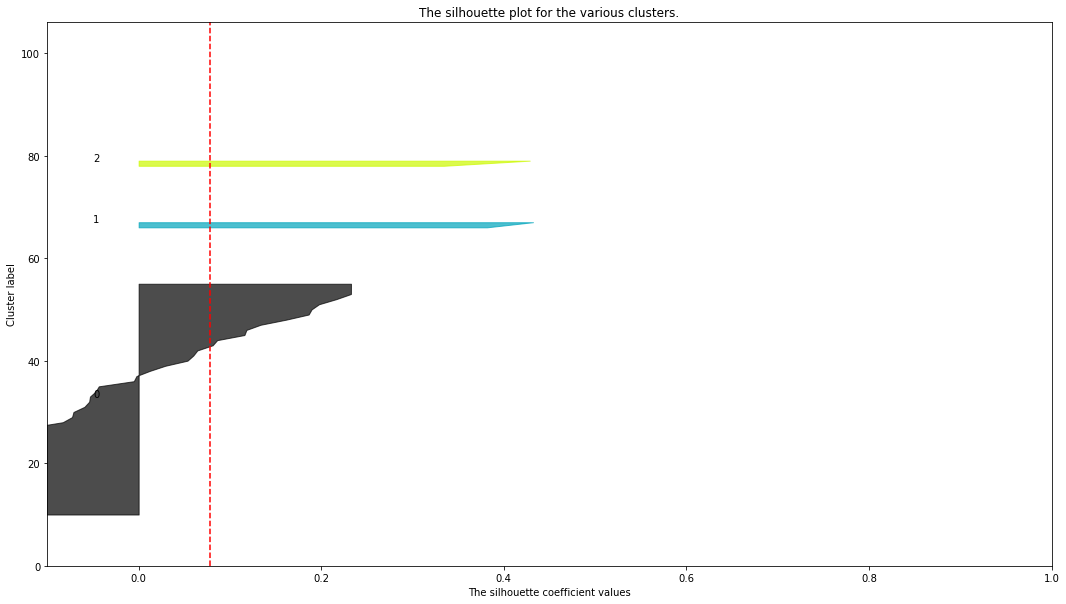

0.07811279668822338


In [155]:
'''
DBSCAN su PAESI
'''

# Parametri

'''
affinity: euclidean, l1,l2, manhattan, cosine
linnkage: single, complete, average, ward
'''

START = 1970
TRAINING_DATA = rate_dt
n_neighbors = 5
eps = 80
min_samples = 2

# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose()).transpose()
print(data.shape)

# Clustering

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data)


# Visualizzazione risultati

labels = clustering.labels_
print(labels)

print(len(labels))

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)


score = plot_silhouette(data, labels, n_cluster)
print(score)



In [ ]:
'''
DBSCAN su ANNI
'''

# Parametri

'''
eps:    3e10-12 per prodt
        50-150 per rate
'''

START = 1970
TRAINING_DATA = rate_dt
n_neighbors = 5
eps = 50
min_samples = 5

# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose())
print(data.shape)

# Clustering

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data)


# Visualizzazione risultati

labels = clustering.labels_
print(labels)

print(len(labels))

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)


score = plot_silhouette(data, labels, n_cluster)
print(score)


/tmp/ipykernel_6802/246339070.py:21: RuntimeWarning: Mean of empty slice
  new_data[i] = np.nanmean(reshaped_row, axis=1)


(189, 10)
189
0 67.1957671957672
1 3.7037037037037033
2 29.100529100529098


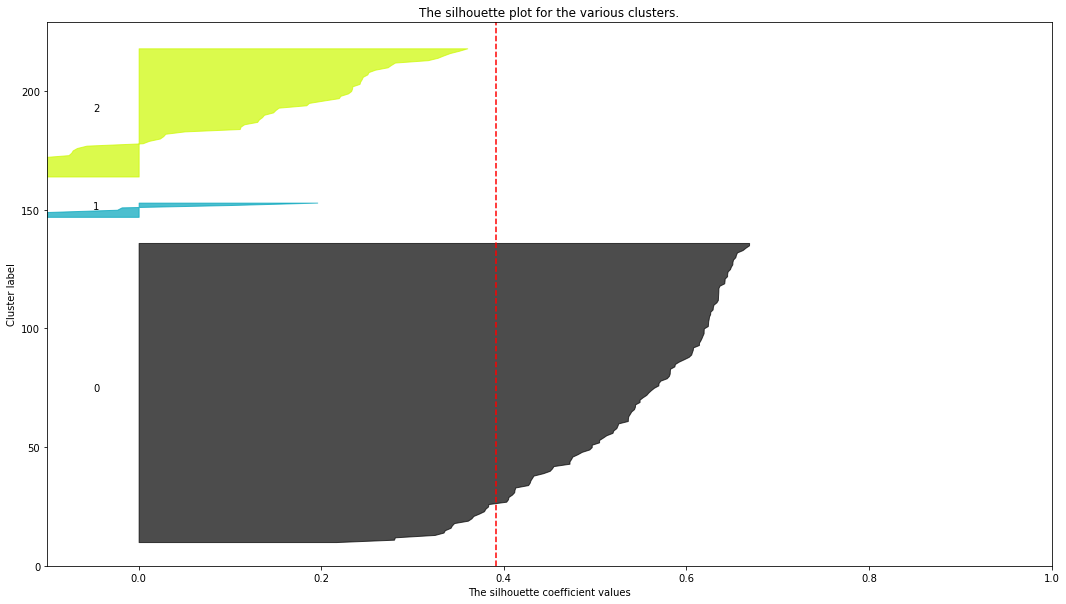

0.3912673866546339


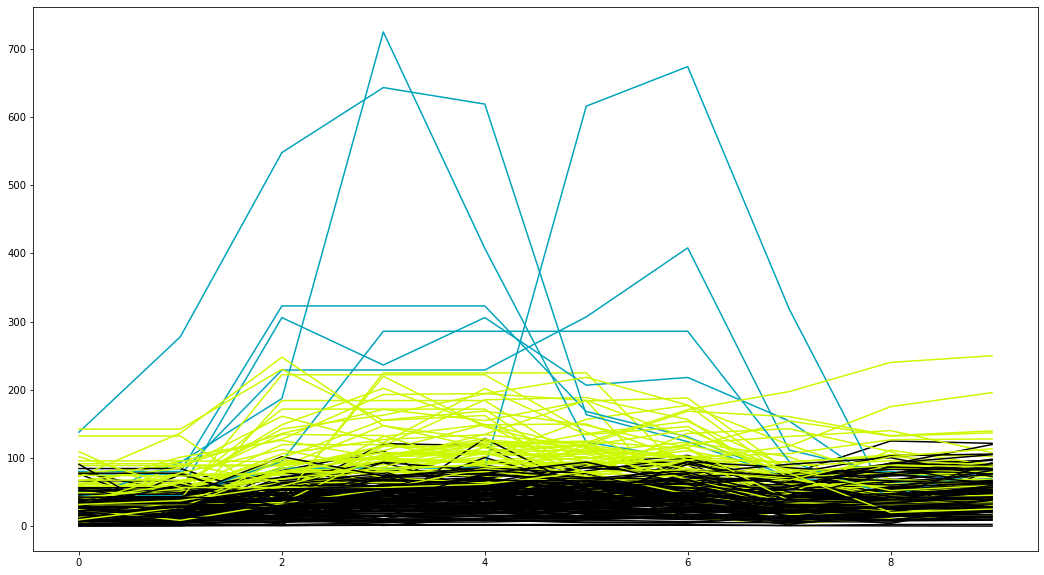

In [23]:
'''
KMEANS con buckets su PAESI
'''

# Parametri


START = 1971
TRAINING_DATA = rate_dt
n_neighbors = 1
n_cluster = 3
n_bucket = 5

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()

new_data = np.zeros((data.shape[0], int(data.shape[1] / n_bucket)))


for i in range(new_data.shape[0]):
    reshaped_row = np.reshape(data[i], (int(data.shape[1]/n_bucket), n_bucket))
    new_data[i] = np.nanmean(reshaped_row, axis=1)


data = new_data
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose()).transpose()
print(data.shape)



# Clustering

clustering = KMeans(n_clusters=n_cluster).fit(data)

# Visualizzazione risultati

labels = clustering.labels_

print(len(labels))

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)


score = plot_silhouette(data, labels, n_cluster)
print(score)
view_clusters(labels, data, [i for i in range(10)])


# Clustering su serie temporali tramite trasformazione


(189, 51)
[0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0
 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0
 1 0 0 0]
0 67.72486772486772
1 32.27513227513227


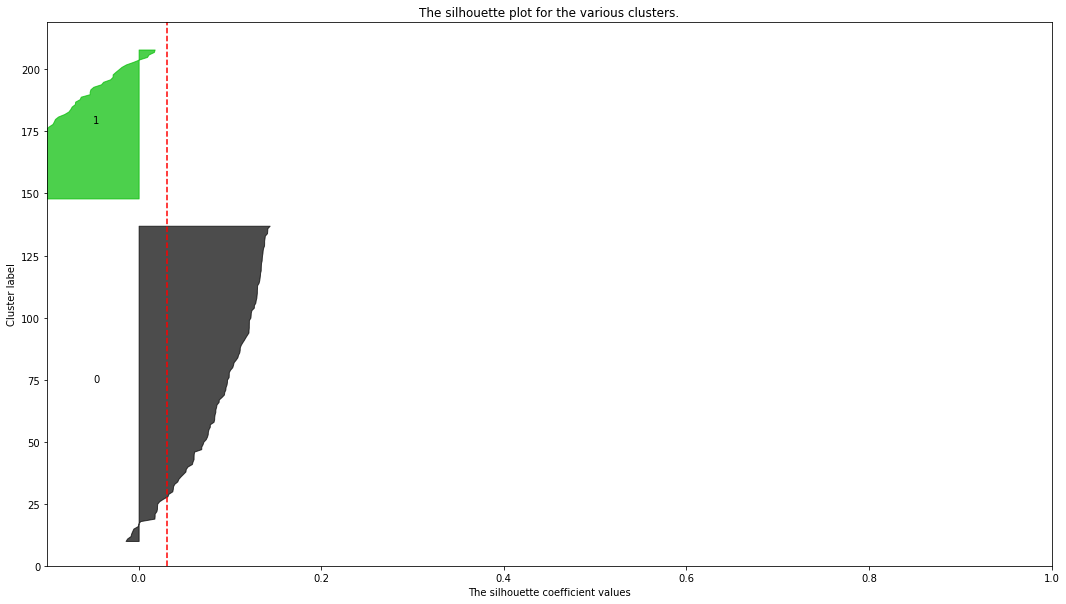

0.031390324473345686


In [164]:
'''
Agglomerative su PAESI
'''

# Parametri

'''
affinity: euclidean, l1,l2, manhattan, cosine
linnkage: single, complete, average, ward
'''

START = 1970
TRAINING_DATA = rate_dt
n_cluster = 2
n_neighbors = 5
affinity = 'cosine'
linkage = 'complete'

# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose()).transpose()
print(data.shape)

# Creazione coefficenti HAAR

cA, cD = pywt.dwt(data, 'haar')


# Clustering


clustering = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, compute_full_tree=True, linkage=linkage).fit(cD)

# Visualizzazione risultati

labels = clustering.labels_

print(labels)

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)


score = plot_silhouette(data, labels, n_cluster)
print(score)




(189, 51)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
0 99.47089947089947
1 0.5291005291005291


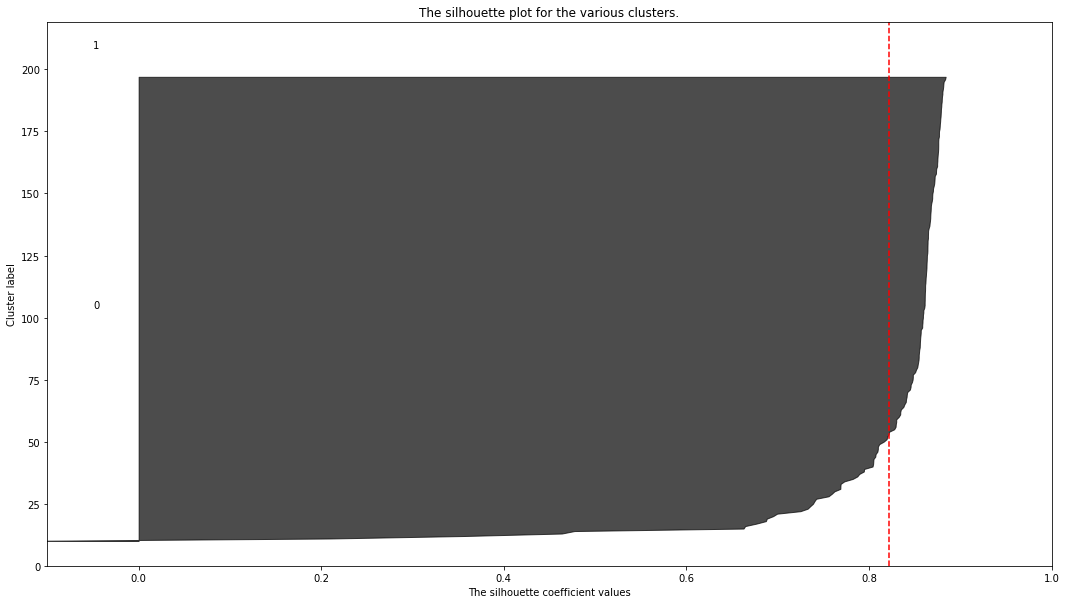

0.8221066748659951


In [165]:
'''
KMEANS su PAESI
'''

# Parametri

'''
affinity: euclidean, l1,l2, manhattan, cosine
linnkage: single, complete, average, ward
'''

START = 1970
TRAINING_DATA = rate_dt
n_cluster = 2
n_neighbors = 5


# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose()).transpose()
print(data.shape)

# Creazione coefficenti HAAR

cA, cD = pywt.dwt(data, 'haar')


# Clustering


clustering = KMeans(n_clusters=n_cluster).fit(cD)

# Visualizzazione risultati

labels = clustering.labels_

print(labels)

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)


score = plot_silhouette(data, labels, n_cluster)
print(score)

# Clustering su serie temporali


(189, 21)
Serbia  ---  Hungary


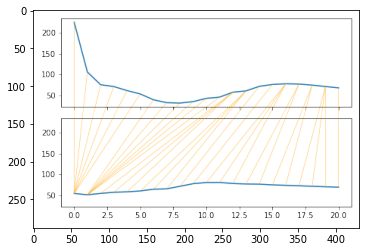

183.21425975807065


In [17]:
'''
Test iniziale distanze con DTW

'''


# Parametri 

START = 2000
TRAINING_DATA = rate_dt
n_neighbors = 5
C1 = 10
C2 = 89


# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose()).transpose()
print(data.shape)

country_list = TRAINING_DATA.loc[:,'name'].to_numpy()


# Differenza tra le serie temporali


print(country_list[C1]," --- " ,country_list[C2])



path = dtw.warping_path(data[C1], data[C2])
dtwvis.plot_warping(data[C1], data[C2], path, filename="warp.png")
img = mpimg.imread('warp.png')
imgplot = plt.imshow(img)
plt.show()

distance = dtw.distance(data[C1], data[C2])
print(distance)

(188, 221)
(188, 221, 1) 

0 96.80851063829788
2 1.5957446808510638
1 1.0638297872340425
3 0.5319148936170213

 0.9547856779145331


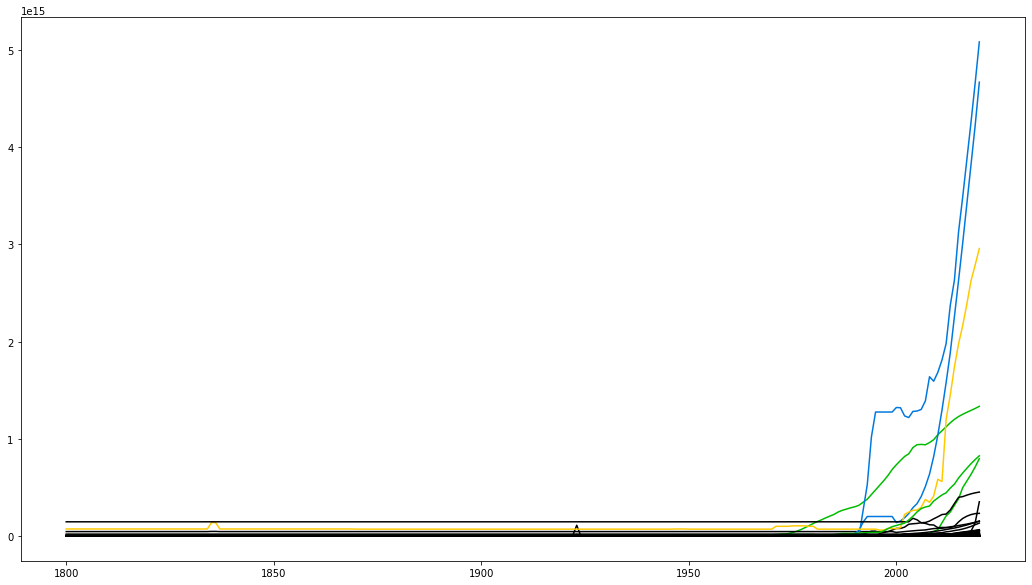

In [36]:
'''
KMeans su serie temporali
'''

# Parametri 

START = 1800
TRAINING_DATA = debt_dt
n_cluster = 4
n_neighbors = 5

# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose()).transpose()

# Creazione serie temporale

ts_data = to_time_series_dataset(data)


print(data.shape)
print(ts_data.shape, '\n')



km = TimeSeriesKMeans(n_clusters=n_cluster, metric='dtw')
km.fit(ts_data)

labels = km.labels_

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)

print('\n', silhouette_score(data, km.labels_, metric='dtw'))

view_clusters(labels, data,  time_data[START - 1800:])


In [ ]:
START = 2000
DATASET = rate_dt


data = DATASET.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=5)
data = imputer.fit_transform(data.transpose()).transpose()
ts_data = to_time_series_dataset(data)

print(data.shape)
print(ts_data.shape)

dtw_distance_matrix = dtw.distance_matrix(ts_data)
print(np.isnan(np.min(dtw_distance_matrix)))





[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


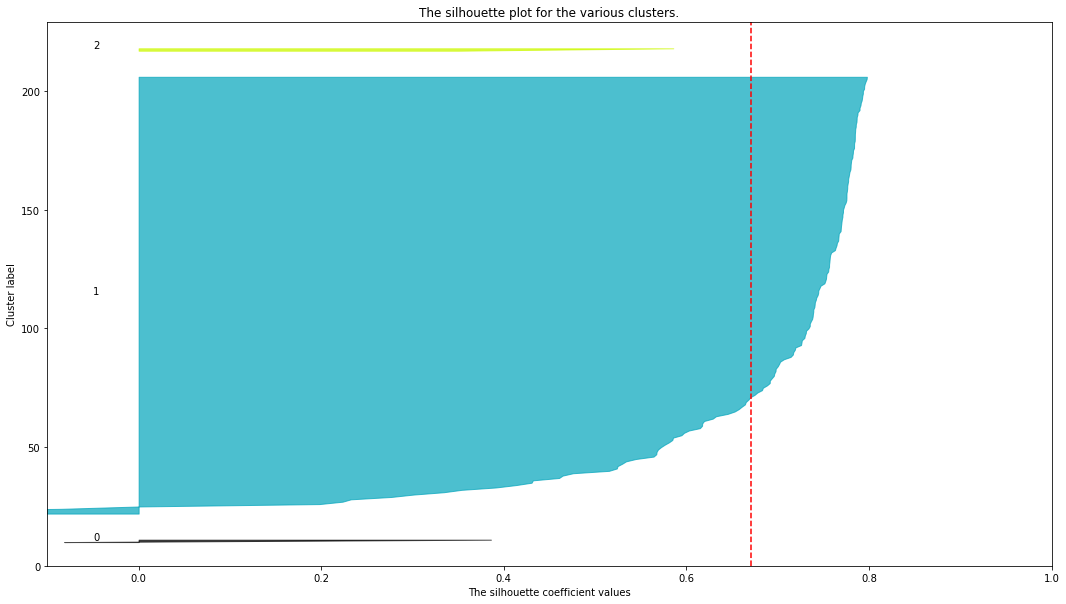

0.6708841644008573


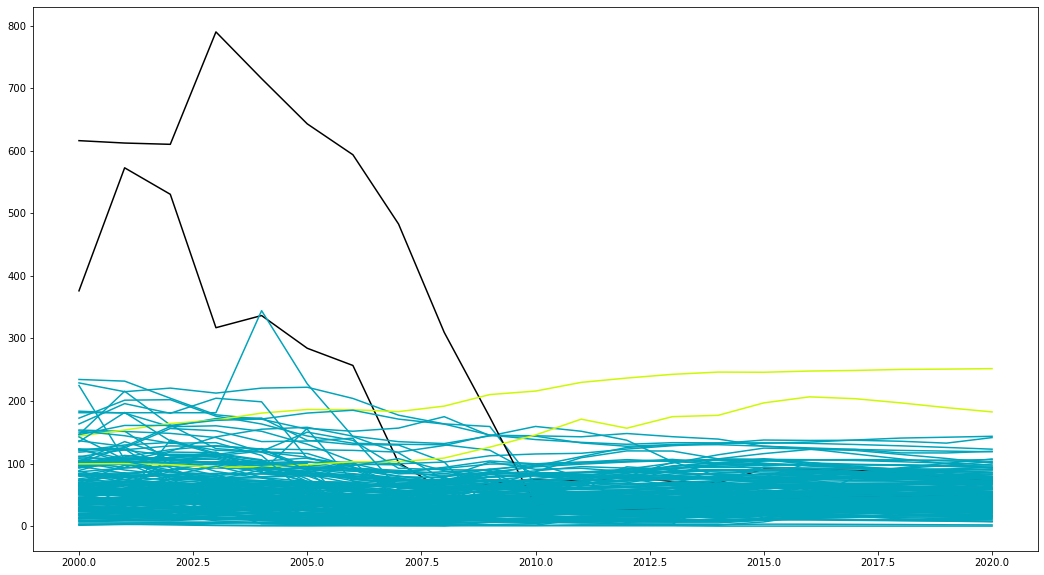

In [91]:
n_cluster = 3

clustering = AgglomerativeClustering(affinity='precomputed', n_clusters=n_cluster,  linkage='average').fit(dtw_distance_matrix)

labels = clustering.labels_
n_cluster = clustering.n_clusters_

print(labels)
score = plot_silhouette(data, labels, n_cluster)
print(score)

view_clusters(labels, data, START)

/tmp/ipykernel_6802/2776643386.py:23: RuntimeWarning: Mean of empty slice
  new_data[i] = np.nanmean(reshaped_row, axis=1)


(189, 5)
(189, 5)
(189, 5, 1) 

0 66.66666666666666
1 2.1164021164021163
2 31.216931216931215

 0.4364075038990374


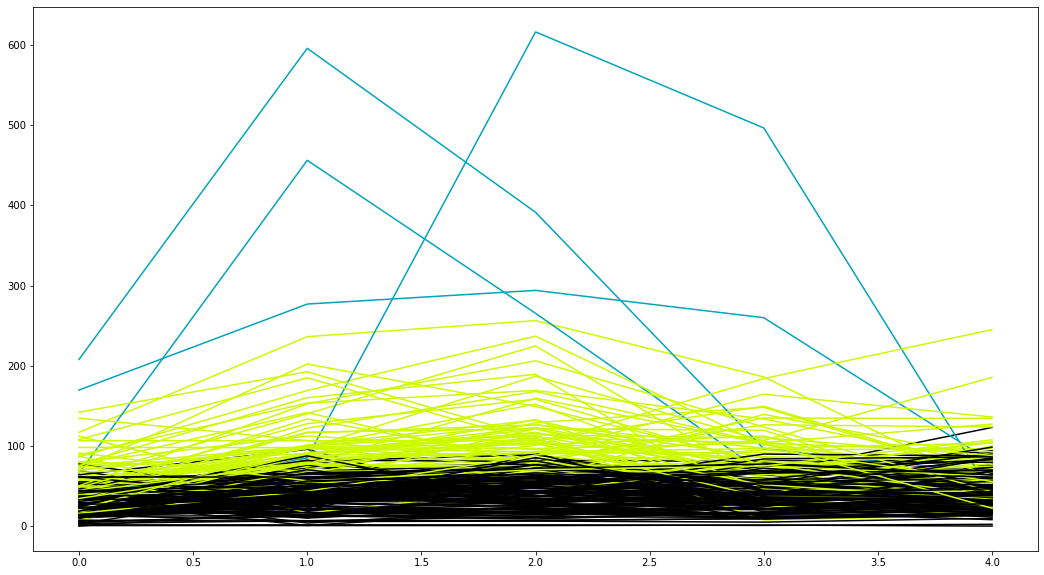

In [30]:
'''
KMeans su serie temporali
'''

# Parametri 

START = 1971
TRAINING_DATA = rate_dt
n_neighbors = 2
n_cluster = 3
n_bucket = 10

# Rimozione dati null tramite KNN

data = TRAINING_DATA.iloc[:, (START - 1800 + 2):].to_numpy()
NEW_DIMENSION = int(data.shape[1] / n_bucket)

new_data = np.zeros((data.shape[0], NEW_DIMENSION))


for i in range(new_data.shape[0]):
    reshaped_row = np.reshape(data[i], (NEW_DIMENSION, n_bucket))
    new_data[i] = np.nanmean(reshaped_row, axis=1)


data = new_data
imputer = KNNImputer(n_neighbors=n_neighbors )
data = imputer.fit_transform(data.transpose()).transpose()
print(data.shape)

# Creazione serie temporale


ts_data = to_time_series_dataset(data)


print(data.shape)
print(ts_data.shape, '\n')



km = TimeSeriesKMeans(n_clusters=n_cluster, metric='dtw')
km.fit(ts_data)

labels = km.labels_

c = Counter(labels)
for a in Counter(c):
    print(a, c.get(a) / len(labels) * 100)



print('\n', silhouette_score(data, km.labels_, metric='dtw'))
view_clusters(labels, data, [i for i in range(NEW_DIMENSION)])


In [ ]:
START = 1970
DATASET = rate_dt


data = DATASET.iloc[:, (START - 1800 + 2):].to_numpy()
imputer = KNNImputer(n_neighbors=5)
data = imputer.fit_transform(data.transpose()).transpose()
ts_data = to_time_series_dataset(data)

print(data.shape)
print(ts_data.shape)

dtw_distance_matrix = dtw.distance_matrix(ts_data)
print(np.isnan(np.min(dtw_distance_matrix)))

